# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"><img src="images/icon102.png" width="38px"></img> **Hopsworks Feature Store** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 03: Model training</span>

<span style="font-width:bold; font-size: 1.4rem;">In this last notebook, we will train a model on the dataset we created in the previous tutorial. We can train our model using standard Python and machine learning frameworks such as Scikit-learn, PySpark, TensorFlow, and PyTorch.</span>

## 🗒️ This notebook is divided in 3 main sections:
1. Loading the training data.
2. Model training.
3. Model's Predictions Visualization.

![tutorial-flow](images/03_model.png)

---
## <span style="color:#ff5f27;"> 🔮 Connecting to Hopsworks Feature Store </span>

In [1]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://ed408010-19ac-11ed-9333-c9e9623aac8a.cloud.hopsworks.ai/p/120
Connected. Call `.close()` to terminate connection gracefully.


---

## <span style="color:#ff5f27;">🪝 Feature View and Training Dataset Retrieval</span>

To retrieve training dataset from Feature Store we retrieve **Feature View** using `FeatureStore.get_feature_view()` method.

Then we can use **Feature View** in order to retrieve **training dataset** using `FeatureView.get_train_test_split()` method.

In [2]:
feature_view = fs.get_feature_view(
    name = 'electricity_feature_view',
    version = 1
)

In [3]:
X_train, y_train, X_test, y_test = feature_view.get_train_test_split(
    training_dataset_version = 2
)

In [4]:
X_train.head()

,index,date,min_temperature,max_temperature,solar_exposure,rainfall,day_of_week,day_of_month,day_of_year,week_of_year,...,rrp_positive,demand_neg_rrp,rrp_negative,demand_pos_rrp,demand_7_mean,demand_7_std,demand_14_mean,demand_14_std,demand_30_mean,demand_30_std
0,159,1433808000000000000,10.3,13.5,8.6,4.0,1,9,160,24,...,36.714275,0.000,0.00,132854.135,129998.740000,16495.684874,130051.376786,14223.745732,129428.621333,11327.293808
1,214,1438560000000000000,7.3,10.8,9.4,6.4,0,3,215,32,...,38.678131,1978.235,-0.66,139473.490,136271.079286,10524.665009,135306.445714,9699.803008,136798.988833,9749.785447
2,600,1471910400000000000,7.0,13.4,14.2,11.0,1,23,236,34,...,73.189594,0.000,0.00,138640.390,129511.422857,8290.864727,128341.507143,8221.684375,132324.000500,9537.407324
3,722,1482451200000000000,12.5,26.3,28.7,0.0,4,23,358,51,...,24.329345,0.000,0.00,112247.945,102714.402143,8694.656642,106622.343929,10913.242534,108621.437333,9282.797942
4,1179,1521936000000000000,17.8,25.4,11.6,13.0,6,25,84,12,...,42.025559,1707.455,-60.45,97211.060,111316.651429,6224.937623,110280.377500,7137.182096,113631.981333,8948.455174


---

## <span style="color:#ff5f27;">🤖 Model Building</span>

### <span style="color:#ff5f27;">📝 Imports</span>

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

### <span style="color:#ff5f27;">🧑🏻‍🔬 RandomForestRegressor</span>

In [6]:
reg = RandomForestRegressor(
    n_estimators = 25,
    max_features = 'sqrt',
    n_jobs = -1,
    random_state = 42
)

reg.fit(X_train.drop(['index','date'], axis = 1),y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=25, n_jobs=-1,
                      random_state=42)

In [7]:
preds = reg.predict(X_test.drop(['index','date'],axis = 1))

r2_score(y_test, preds)

0.9691784533829766

---

## <span style="color:#ff5f27;">🔬 🧬 Model Predictions Visualization</span>

In [8]:
X_test['preds'] = preds
X_train['target'] = y_train
X_train.date = pd.to_datetime(X_train.date)
X_test.date = pd.to_datetime(X_test.date)

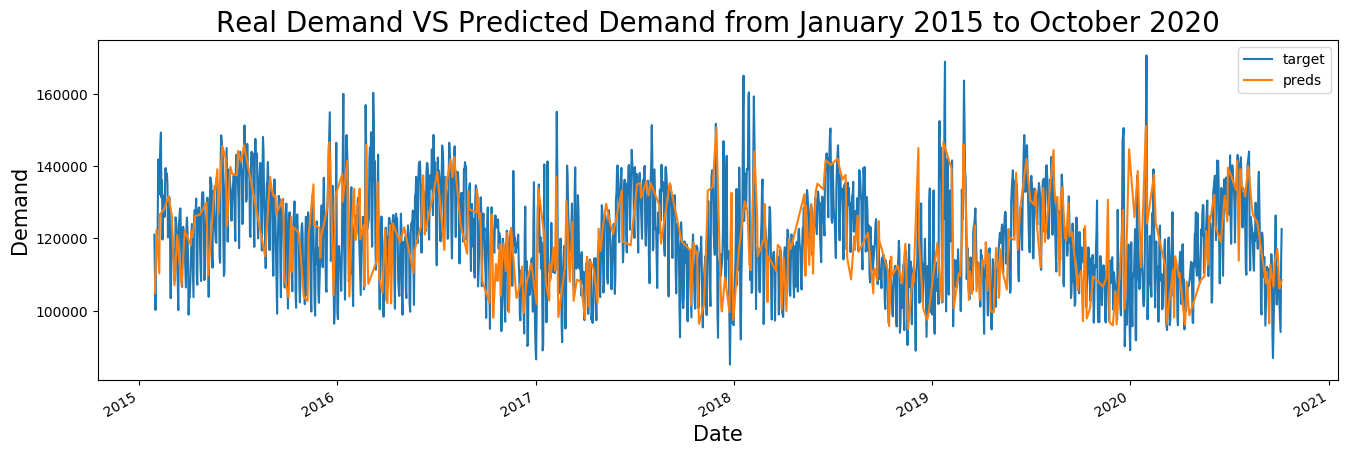

In [9]:
fig,ax = plt.subplots(figsize = (16,5))

X_train.plot('date','target', ax = ax)
X_test.plot('date','preds', ax = ax)

ax.set_xlabel('Date',fontsize = 15)
ax.set_ylabel('Demand',fontsize = 15)
ax.set_title('Real Demand VS Predicted Demand from January 2015 to October 2020',fontsize = 20)

plt.show()

---
## <span style='color:#ff5f27'>👮🏼‍♀️ Model Registry</span>

In [10]:
import hsml

conn = hsml.connection()
mr = conn.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [11]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train.drop(['index','date','target'],axis = 1))
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_schema.to_dict()

{'input_schema': {'columnar_schema': [{'name': 'min_temperature',
    'type': 'float64'},
   {'name': 'max_temperature', 'type': 'float64'},
   {'name': 'solar_exposure', 'type': 'float64'},
   {'name': 'rainfall', 'type': 'float64'},
   {'name': 'day_of_week', 'type': 'int64'},
   {'name': 'day_of_month', 'type': 'int64'},
   {'name': 'day_of_year', 'type': 'int64'},
   {'name': 'week_of_year', 'type': 'int64'},
   {'name': 'month', 'type': 'int64'},
   {'name': 'quarter', 'type': 'int64'},
   {'name': 'year', 'type': 'int64'},
   {'name': 'school_day', 'type': 'int64'},
   {'name': 'holiday', 'type': 'int64'},
   {'name': 'rrp', 'type': 'float64'},
   {'name': 'frac_at_neg_rrp', 'type': 'float64'},
   {'name': 'rrp_positive', 'type': 'float64'},
   {'name': 'demand_neg_rrp', 'type': 'float64'},
   {'name': 'rrp_negative', 'type': 'float64'},
   {'name': 'demand_pos_rrp', 'type': 'float64'},
   {'name': 'demand_7_mean', 'type': 'float64'},
   {'name': 'demand_7_std', 'type': 'float64'

In [12]:
import joblib

pkl_file_name = "forest.pkl"

joblib.dump(reg, pkl_file_name)

model = mr.sklearn.create_model(
    name = "forestmodel",
    input_example = X_train.drop(['index','date','target'],axis = 1).sample(),
    model_schema = model_schema
)

model.save(pkl_file_name)

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://ed408010-19ac-11ed-9333-c9e9623aac8a.cloud.hopsworks.ai/p/120/models/forestmodel/1


Model(name: 'forestmodel', version: 1)

---

## <span style='color:#ff5f27'>🚀 Model Deployment</span>

In [13]:
%%writefile predict_example.py
import os
import joblib
import numpy as np
import pandas as pd

class Predict(object):

    def __init__(self):
        """ Initializes the serving state, reads a trained model"""        
        # load the trained model
        self.model = joblib.load(os.environ["ARTIFACT_FILES_PATH"] + "/forest.pkl")
        print("Initialization Complete")

    def predict(self, inputs):
        """ Serves a prediction request usign a trained model"""
        return self.model.predict(np.array(inputs).reshape(1, -1)).tolist()

Writing predict_example.py


In [14]:
import os
dataset_api = project.get_dataset_api()

uploaded_file_path = dataset_api.upload("predict_example.py", "Models", overwrite=True)
predictor_script_path = os.path.join("/Projects", project.name, uploaded_file_path)

Uploading: 0.000%|          | 0/519 elapsed<00:00 remaining<?

In [15]:
# Use the model name from the previous notebook.
model = mr.get_model("forestmodel", version = 1)

# Give it any name you want
deployment = model.deploy(
    name="forestmodeldeploy", 
    model_server="PYTHON",
    serving_tool='KSERVE',
    script_file=predictor_script_path
)

Deployment created, explore it at https://ed408010-19ac-11ed-9333-c9e9623aac8a.cloud.hopsworks.ai/p/120/deployments/1029
Before making predictions, start the deployment by using `.start()`


In [16]:
# get Hopsworks Model Serving
ms = project.get_model_serving()

# get deployment object
deployment = ms.get_deployment("forestmodeldeploy")

Connected. Call `.close()` to terminate connection gracefully.


In [17]:
deployment.start(await_running = 120)

  0%|          | 0/1 [00:00<?, ?it/s]

Start making predictions by using `.predict()`


In [18]:
deployment.get_logs()

Explore all the logs and filters in the Kibana logs at https://ed408010-19ac-11ed-9333-c9e9623aac8a.cloud.hopsworks.ai/p/120/deployments/1029

Instance name: forestmodeldeploy-predictor-default-00001-deployment-fc8c7wlkq7
[I 220817 19:39:28 kserve-component-server:95] Initializing predictor for deployment: forestmodeldeploy
[I 220817 19:39:28 kfserver:150] Registering model: forestmodeldeploy
[I 220817 19:39:28 kfserver:120] Setting asyncio max_workers as 5
[I 220817 19:39:28 kfserver:127] Listening on port 8080
[I 220817 19:39:28 kfserver:129] Will fork 1 workers




---
## <span style='color:#ff5f27'>🔮 Predicting</span>

In [19]:
batch = feature_view.get_batch_data()
batch.sort_values('date',inplace = True)
batch.drop(['index','date'], axis = 1, inplace = True)
batch.head()

2022-08-17 19:39:31,209 INFO: USE `electricity_featurestore`
2022-08-17 19:39:32,084 INFO: WITH right_fg0 AS (SELECT *
FROM (SELECT `fg2`.`index` `index`, `fg2`.`date` `date`, `fg2`.`min_temperature` `min_temperature`, `fg2`.`max_temperature` `max_temperature`, `fg2`.`solar_exposure` `solar_exposure`, `fg2`.`rainfall` `rainfall`, `fg2`.`day_of_week` `day_of_week`, `fg2`.`day_of_month` `day_of_month`, `fg2`.`day_of_year` `day_of_year`, `fg2`.`week_of_year` `week_of_year`, `fg2`.`month` `month`, `fg2`.`quarter` `quarter`, `fg2`.`year` `year`, `fg2`.`index` `join_pk_index`, `fg2`.`date` `join_evt_date`, `fg0`.`school_day` `school_day`, `fg0`.`holiday` `holiday`, RANK() OVER (PARTITION BY `fg2`.`index`, `fg2`.`date` ORDER BY `fg0`.`date` DESC) pit_rank_hopsworks
FROM `electricity_featurestore`.`weather_fg_1` `fg2`
INNER JOIN `electricity_featurestore`.`calendar_fg_1` `fg0` ON `fg2`.`index` = `fg0`.`index` AND `fg2`.`date` >= `fg0`.`date`) NA
WHERE `pit_rank_hopsworks` = 1), right_fg1 AS (S

,min_temperature,max_temperature,solar_exposure,rainfall,day_of_week,day_of_month,day_of_year,week_of_year,month,quarter,...,rrp_positive,demand_neg_rrp,rrp_negative,demand_pos_rrp,demand_7_mean,demand_7_std,demand_14_mean,demand_14_std,demand_30_mean,demand_30_std
1409,13.1,21.0,27.6,0.0,4,30,30,5,1,1,...,21.029356,0.0,0.0,121018.15,113361.206429,8840.007476,119750.684643,17637.057172,121135.323333,16463.479261
1811,14.3,20.2,26.2,0.0,5,31,31,5,1,1,...,16.538847,0.0,0.0,103822.97,111577.260714,9388.612319,120068.660357,17277.849041,121274.921333,16291.746026
795,13.2,19.0,17.3,9.2,6,1,32,5,2,1,...,14.578844,0.0,0.0,100178.84,111894.315000,8875.547703,120243.666786,17045.002549,120294.015667,16654.688684
0,13.5,21.1,23.9,3.8,0,2,33,6,2,1,...,22.270032,0.0,0.0,118694.16,114026.412143,8377.113294,120373.024643,17024.396712,119507.136333,16128.447829
796,16.1,20.0,22.7,0.0,1,3,34,6,2,1,...,27.003832,0.0,0.0,122880.13,114667.386429,8920.937447,119938.167857,16864.969397,120125.450167,15880.221937


In [20]:
batch.shape

(2073, 25)

In [21]:
def get_predictions(row, deployment = deployment):
    data = {
        'inputs': row.tolist()
    }
    return deployment.predict(data)

In [22]:
predictions = [pred['predictions'][0] for pred in batch[:500].apply(get_predictions,axis = 1)]

predictions[:5]

[120298.94079999997,
 104919.54960000001,
 100194.5012,
 118230.88620000001,
 122467.16240000004]

---